In [1]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2DTranspose,concatenate,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.layers import LeakyReLU,ReLU
 

2023-01-11 15:08:44.316361: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-11 15:08:44.316499: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#trainsB = 962
#trainA = 1231
#testA = 309
#testB = 238
#import os
 

In [3]:
train_A = []
path = r"/kaggle/input/summer2winter-yosemite/trainA/"
l = os.listdir(path)
for im in l:
    img = Image.open(path+im)
    img_array = np.array(img)
    train_A.append(img_array)

In [4]:
train_A = np.array(train_A)
train_A.shape

(1231, 256, 256, 3)

In [5]:
train_B = []
path = r"/kaggle/input/summer2winter-yosemite/trainB/"
l = os.listdir(path)
for im in l:
    img = Image.open(path+im)
    img_array = np.array(img)
    train_B.append(img_array)
train_B = np.array(train_B)
train_B.shape

(962, 256, 256, 3)

In [6]:
train_A = train_A[:train_B.shape[0],:,:]
train_A.shape

(962, 256, 256, 3)

In [7]:
test_A = []
path = r"/kaggle/input/summer2winter-yosemite/testA/"
l = os.listdir(path)
for im in l:
    img = Image.open(path+im)
    img_array = np.array(img)
    test_A.append(img_array)
test_A = np.array(test_A)
test_A.shape

(309, 256, 256, 3)

In [8]:
test_B = []
path = r"/kaggle/input/summer2winter-yosemite/testB/"
l = os.listdir(path)
for im in l:
    img = Image.open(path+im)
    img_array = np.array(img)
    test_B.append(img_array)
test_B = np.array(test_B)
test_B.shape

(238, 256, 256, 3)

In [9]:
test_A = test_A[:test_B.shape[0],:,:]
test_A.shape

(238, 256, 256, 3)

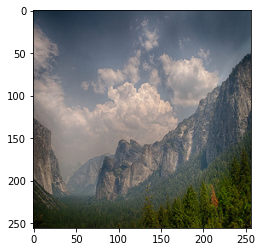

In [10]:
plt.imshow(train_A[1])

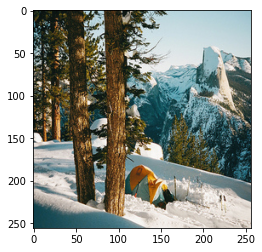

In [11]:
plt.imshow(train_B[1])

**The set A has summer landscapes**
**The set B has winter landscapes**

In [12]:
train_A = (((train_A)/128)+1)/2
train_B = (((train_B-128)/128)+1)/2
test_A = (((test_A-128)/128)+1)/2
test_B = (((test_B-128)/128)+1)/2

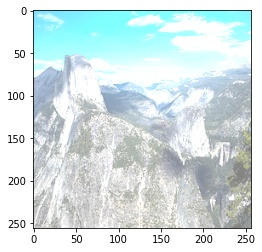

In [13]:
plt.imshow(train_A[0])

In [14]:
def residual_block(f,inp):
    x = Conv2D(filters=f,kernel_size=(3,3),strides=1,padding="same")(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=f,kernel_size=(3,3),strides=1,padding="same")(x)
    x = BatchNormalization()(x)
    return x

In [15]:
def generator(input_shape):
    filter = 64
    inp = tf.keras.layers.Input(shape=(input_shape,input_shape,3))
    first = Conv2D(filters=filter,kernel_size = (7,7),strides=1,padding="same")(inp)
    second = Conv2D(filters=2*filter,strides = 2,kernel_size=(3,3),padding="same")(first)
    third = Conv2D(filters=4*filter,kernel_size = (3,3),strides = 2,padding="same")(second)
    
    fourth = residual_block(64,third)
    fourth = residual_block(64,fourth)
    fourth = residual_block(64,fourth)
    fourth = residual_block(64,fourth)
    fourth = residual_block(64,fourth)
    fourth = residual_block(64,fourth)
    fourth = residual_block(64,fourth)
    fourth = residual_block(64,fourth)
    fourth = residual_block(64,fourth)
    
    fifth = Conv2DTranspose(kernel_size =(3,3),filters=2*filter,strides = (2,2),padding="same",output_padding=(1,1))(fourth)
    sixth = Conv2DTranspose(kernel_size=(3,3),strides = (2,2),padding="same",output_padding=(1,1),filters=filter)(fifth)
    output = Conv2DTranspose(kernel_size=(3,3),strides = (1,1),padding="same",filters=3)(sixth)
    model = tf.keras.models.Model(inp,output)
    
    return model

In [16]:
gen_model = generator(256)
gen_model.summary()

2023-01-11 15:09:12.341416: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-11 15:09:12.344745: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-11 15:09:12.344791: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-11 15:09:12.344820: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5d764ccf8e03): /proc/driver/nvidia/version does not exist
2023-01-11 15:09:12.345203: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      9472      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        147520    
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 64)        0     

In [17]:
def discriminator(inp_size):
    f = 64
    inp = tf.keras.layers.Input(shape=(inp_size,inp_size,3))
    first = Conv2D(filters=f,kernel_size=(4,4),strides=(2,2),padding="same")(inp)
    first = Conv2D(filters=2*f,kernel_size=(4,4),strides=(2,2),padding="same")(first)
    first = Conv2D(filters=4*f,kernel_size=(4,4),strides=(2,2),padding="same")(first)
    first = Conv2D(filters=8*f,kernel_size=(4,4),strides=(1,1),padding="same")(first)
    output = Conv2D(filters=1,kernel_size=(4,4),strides=(2,2),padding="same")(first)
    model = tf.keras.models.Model(inp,output)
    opt = Adam(learning_rate = 0.0002)
    model.compile(loss="mse",optimizer=opt)
    return model

In [18]:
dis_model = discriminator(256)
dis_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 256)       524544    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 512)       2097664   
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 1)         8193      
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
_________________________________________________

In [19]:
def composite_model(g_model1,g_model2,d_model,img_shape):
    d_model.trainable = False
    g_model2.trainable = False
    g_model1.trainable = True
    
    img_input = tf.keras.layers.Input(shape=(img_shape,img_shape,3))
    out_gen1 = g_model1(img_input)
    out_dmodel = d_model(out_gen1)
    
    img_input2 = tf.keras.layers.Input(shape=(img_shape,img_shape,3))
    out_gen_identity = g_model1(img_input2)
    
    out_gen_forward = g_model2(out_gen1)
    
    out_gen2_model2 = g_model2(img_input2)
    out_gen_back = g_model1(out_gen2_model2)
    
    model = tf.keras.models.Model([img_input,img_input2],[out_dmodel,out_gen_identity,out_gen_forward,out_gen_back])
    opt = Adam(learning_rate = 0.0002,beta_1 = 0.5)
    model.compile(loss=["mse","mae","mae","mae"],optimizer=opt)
    
    return model

In [20]:
def fake_image(X,g_model,out_shape):
    y = tf.zeros((X.shape[0],out_shape,out_shape,1))
    gen_images = g_model(X,training=False)
    return gen_images,y    

In [21]:
def train(XA,XB,epochs,d_modelA2B,d_modelB2A,g_modelA2B,g_modelB2A,combine_A2B,combine_B2A,n_batches):
    for i in range(epochs):
        d_lossA,d_lossB,g_lossA,g_lossB = 0,0,0,0
        n=int(epochs/n_batches)
        for j in range(0,n,n_batches):
            xA_real,yA_real = XA[j:j+50],tf.ones((50,16,16,1))
            xA_fake,yA_fake = fake_image(xA_real,g_modelA2B,16)
            xB_real,yB_real = XB[j:j+50],tf.ones((50,16,16,1))
            xB_fake,yB_fake = fake_image(xB_real,g_modelB2A,16)
            
            gen2_loss,_,_,_,_ = combine_B2A.train_on_batch([xB_real,xA_real],[yA_real,xB_real,xA_real,xA_real])
            dA2B_loss_real = d_modelA2B.train_on_batch(xA_real,yA_real)
            dA2B_loss_fake = d_modelA2B.train_on_batch(xA_fake,yA_fake)
            
            gen1_loss,_,_,_,_=combine_A2B.train_on_batch([xA_real,xB_real],[yB_real,xA_real,xB_real,xB_real])
            dB2A_loss_real = d_modelB2A.train_on_batch(xB_real,yB_real)
            dB2A_loss_fake = d_modelB2A.train_on_batch(xB_fake,yB_fake)
            d_lossA+=dA2B_loss_real+dA2B_loss_fake
            d_lossB+=dB2A_loss_real+dB2A_loss_fake
            g_lossA+=gen1_loss
            g_lossB+=gen2_loss
            
            
        if(i%2==0):
            print("Epochs: ",i)
            print("Discriminator A2B  loss: ",d_lossA)
            print("Discriminator B2A loss: ",d_lossB)
            print("Generator A2B loss: ",g_lossA)
            print("Generator B2A loss: ",g_lossB)
            print("\n")

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    genA2B = generator(256)
    genB2A = generator(256)
    disA2B = discriminator(256)
    disB2A = discriminator(256)
    compA2B = composite_model(genA2B,genB2A,disA2B,256)
    compB2A = composite_model(genB2A,genA2B,disB2A,256)
    train(train_A,train_B,300,disA2B,disB2A,genA2B,genB2A,compA2B,compB2A,10)

2023-01-11 15:35:32.449006: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-01-11 15:35:32.449164: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2023-01-11 15:35:32.456487: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-01-11 15:35:32.456906: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


Epochs:  0
Discriminator A2B  loss:  53.91505486777896
Discriminator B2A loss:  47.74494347890868
Generator A2B loss:  11.761594295501709
Generator B2A loss:  11.252285957336426


Epochs:  2
Discriminator A2B  loss:  2.916101149749011
Discriminator B2A loss:  1.6071312670828775
Generator A2B loss:  9.659671783447266
Generator B2A loss:  9.189671039581299


Epochs:  4
Discriminator A2B  loss:  0.8648759834468365
Discriminator B2A loss:  0.981552891433239
Generator A2B loss:  8.742451667785645
Generator B2A loss:  8.331767082214355


Epochs:  6
Discriminator A2B  loss:  0.7356424108147621
Discriminator B2A loss:  0.4441041499376297
Generator A2B loss:  8.366170406341553
Generator B2A loss:  7.924306392669678


Epochs:  8
Discriminator A2B  loss:  0.4959401339292526
Discriminator B2A loss:  0.40546124428510666
Generator A2B loss:  7.569698333740234
Generator B2A loss:  7.308335304260254


Epochs:  10
Discriminator A2B  loss:  0.5658097714185715
Discriminator B2A loss:  0.5282593220472336


In [ ]:
plt.imshow(train_A[0])

In [ ]:
out = genA2B(train_A[:2])
plt.imshow(out[0],cmap="gray")